<a href="https://colab.research.google.com/github/Sanford-Lab/satellite_cnns/blob/main/1_dd_kenya_apache.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Kenya project prediction notebook using an [Apache-Beam workflow](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/mai[…]ple-and-planet-ai/land-cover-classification/README.ipynb). And




https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/people-and-planet-ai/land-cover-classification/cloud-tensorflow.ipynb#scrollTo=D8Kwmqa8CpQV



---


To Do:


*   **FIX** misaligned tensor (under Train Model)
*   Check  `target` variable
*   Add block descriptions
*   Add descriptions



# Initial Software and Libraries

In [ ]:
#After running this cell, restart your kernel and run it again to properly import geemap
#import subprocess

# try:
#     import geemap
# except ImportError:
#     print('Installing geemap ...')
    
#     !pip install earthengine-api



## Install the proper modules and then **restarts runtime**


For standardization, we're pulling requirements directly from the git repo from [GoogleCloudPlatform](https://github.com/GoogleCloudPlatform)

In [ ]:
repo_url = "https://raw.githubusercontent.com/GoogleCloudPlatform/python-docs-samples/main/people-and-planet-ai/land-cover-classification"

!wget --quiet {repo_url}/requirements.txt

In [ ]:
!pip install --quiet --upgrade pip

In [ ]:
# Install the dependencies.
!pip install --quiet -r requirements.txt

# Restart the runtime by ending the process.
exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.5/515.5 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... 

**RESTART RUNTIME** (Runtime<Restart)

## Google Setup

Input your Google Cloud project id (might be different from name)

In [ ]:
from __future__ import annotations

import os
from google.colab import auth

auth.authenticate_user()

# Please fill in these values.
project = "ls-test-3-24" #@param {type:"string"}

# Quick input validations.
assert project, "ERROR: Make sure you are providing a valid Google Cloud project ID"

# Set GOOGLE_CLOUD_PROJECT for google.auth.default().
os.environ['GOOGLE_CLOUD_PROJECT'] = project

# Set the gcloud project for other gcloud commands.
!gcloud config set project {project}

Updated property [core/project].


In [ ]:
import ee
import google.auth

credentials, _ = google.auth.default()
ee.Initialize(
    credentials.with_quota_project(None),
    project=project,
    opt_url="https://earthengine-highvolume.googleapis.com",
)

### Cloud Storage Setup

You must have write access to a bucket to run this demo!  To run it read-only, use the demo bucket below, but note that writes to this bucket will not work.

In [ ]:
# INSERT YOUR BUCKET HERE:
bucket = 'kenya-bucket'  #@param {type:"string"}
location = "us-central1" #@param {type:"string"}

## Other Configurations

In [ ]:
# Defining neccessary functions

def mask_clouds_landsat(image: ee.Image) -> ee.Image:
  # Bits 3 and 5 are cloud shadow and cloud, respectively
  cloudShadowBitMask = (1 << 3) # 1000 in base 2
  cloudsBitMask = (1 << 5) # 100000 in base 2

  # Get the pixel QA band
  qa = image.select('pixel_qa')

  #Both flags should be set to zero, indicating clear conditions
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).bitwiseAnd(qa.bitwiseAnd(cloudsBitMask).eq(0))

  # Mask image with clouds and shadows
  return image.updateMask(mask)


def get_input_image(year: int, default_value: float = 1000.0) -> ee.Image:
  return(
      ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")
      .filterDate(f'{year}-01-01', f'{year}-12-31')
      .map(mask_clouds_landsat)
      .select("B.*")
      .median()
      .unmask(default_value)
      .float()
  )


def cloudMaskL457(image): 
  qa = image.select('pixel_qa')
  # If the cloud bit (5) is set and the cloud confidence (7) is high
  # or the cloud shadow bit is set (3), then it's a bad pixel.
  cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
  # Remove edge pixels that don't occur in all bands
  mask2 = image.mask().reduce(ee.Reducer.min())
  return image.updateMask(cloud.Not()).updateMask(mask2)

In [ ]:
import tensorflow as tf
print("tf version: {}".format(tf.__version__))
import folium

opticalBands = ['B3','B2','B1'] #RGB
thermalBands = ['B4','B3'] #NIR

# Specify inputs (Landsat bands) to the model and the response variable.

BANDS = ['R', 'G', 'B', 'NDVI']
RESPONSE = 'target'

CENSUS_YR = '2009'  #@param {type:"string"}

#Download Kenya Data and create Raster of villages
census = ee.Image('projects/sanford-project-04a9/assets/Kenya/kenya_census_' + CENSUS_YR + '_rast')

# #Get Kenya Feature collection
kenya = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filter(ee.Filter.eq('country_na','Kenya')).set('ORIG_FID',0)

# Geometry selects from all of Kenya
image = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR").filterDate(CENSUS_YR + '-01-01', CENSUS_YR + '-12-31')\
            .map(cloudMaskL457)\
            .median()\
            .clip(kenya.geometry().buffer(10000))\
            
image_ndvi = image.normalizedDifference(thermalBands).rename(['NDVI'])
image_rgb = image.select(opticalBands).rename(['R','G','B']) 
image = image_rgb.addBands(image_ndvi)

target = census.select('b1').rename("target")



tf version: 2.11.0


In [ ]:
print(image.bandNames().getInfo())

['R', 'G', 'B', 'NDVI']


In [ ]:
print(target.getInfo())

{'type': 'Image', 'bands': [{'id': 'target', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [29676, 37426], 'crs': 'EPSG:32737', 'crs_transform': [30, 0, -67088.3816999998, 0, -30, 10605534.1865]}], 'version': 1667329384912485, 'id': 'projects/sanford-project-04a9/assets/Kenya/kenya_census_2009_rast', 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[33.899676480467825, -3.712381049241454], [33.89351506051154, -4.661100260662413], [37.900507946594495, -4.678851591182628], [41.91295489440698, -4.673655155923738], [41.90670508116313, -2.7713382186237463], [41.90334965079649, -0.23517632895609153], [41.90379440308304, 1.032915523138402], [41.90893442251192, 3.5690508582490628], [41.916536101341734, 5.471324856577909], [37.899154212658445, 5.477412980838261], [33.88725958188004, 5.456615444350572], [33.902203461985884, 3.2433133930818694], [33.90731169057764, 1.978657066626101], [33.910330837555634, 0.08162750001535511], [33.9092551841757, 

In [ ]:
import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [ ]:
i_map = folium.Map(location=[0, 37], zoom_start = 6)

i_map.add_ee_layer(target, None, 'census map')
display(i_map)

In [ ]:
# Census mask visualization
c_map = folium.Map(location=[0, 37], zoom_start = 6)
og_img = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR").filterDate(CENSUS_YR + '-01-01', CENSUS_YR + '-12-31')\
              .map(cloudMaskL457)\
              .median()\
              .clip(kenya.geometry().buffer(10000))\

c_map.add_ee_layer(image, None, 'census mask map')
display(c_map)

### View imagery
Census target and LANDSAT7 

In [ ]:
# Census mask visualization
c_map = folium.Map(location=[0, 37], zoom_start = 6)

c_map.add_ee_layer(target, None, 'census target map')
display(c_map)

In [ ]:
# Image mask visualization
mapid = image.getMapId({'bands': ['R', 'G', 'B'], 'min': 0, 'max': 3000})
map = folium.Map(location=[0, 37], zoom_start = 6)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

# Training

## Sampling

Currently using random sampling in the Kenyan geometry

In [ ]:
from typing import Iterable

SAMPLE_SEED = 0
NUM_POINTS = 4

# seed: int, region = region: ee.Geometry, image = image: ee.Image, 
#    points_per_class = points_per_class: int, scale = scale: int
def sample_points(
   seed: int, region = None, image = None, num_points = None, scale = None
) -> Iterable[tuple[float, float]]:

    feature_collection = ee.FeatureCollection(image.geometry())
    points = feature_collection.randomPoints(image.geometry(), points = num_points,seed=seed)


    for point in points.toList(points.size()).getInfo():
      yield point["geometry"]["coordinates"]

# Kenya Region
region = kenya.geometry()
labels_image = target
for point in sample_points(SAMPLE_SEED, region, labels_image, num_points=NUM_POINTS, scale=1000):
  print(point)

[38.795573673803595, 1.1104279881486983]
[41.79166552412254, 5.403461144688108]
[41.0971379543607, -3.881343561013298]
[41.13595469478783, 0.8537859018080317]


## Get training examples

In [ ]:
import io
import numpy as np
import requests
from google.api_core import exceptions, retry

@retry.Retry(deadline=10 * 60)  # seconds
def get_patch(image: ee.Image, lonlat: tuple[float, float], patch_size: int, scale: int) -> np.ndarray:
    point = ee.Geometry.Point(lonlat)
    url = image.getDownloadURL({
        "region": point.buffer(scale * patch_size / 2, 1).bounds(1),
        "dimensions": [patch_size, patch_size],
        "format": "NPY",
    })

    # If we get "429: Too Many Requests" errors, it's safe to retry the request.
    # The Retry library only works with `google.api_core` exceptions.
    response = requests.get(url)
    if response.status_code == 429:
        raise exceptions.TooManyRequests(response.text)

    # Still raise any other exceptions to make sure we got valid data.
    response.raise_for_status()
    return np.load(io.BytesIO(response.content), allow_pickle=True)

Helper functions to get the inputs and labels patches of pixels. We'll use this function both for getting inputs for the training examples, and for predictions later on.

In [ ]:
from numpy.lib.recfunctions import structured_to_unstructured

def get_input_patch(image, year: int, lonlat: tuple[float, float], patch_size: int) -> np.ndarray:
    patch = get_patch(image, lonlat, patch_size, scale=30)
    return structured_to_unstructured(patch)

def get_label_patch(image, lonlat: tuple[float, float], patch_size: int) -> np.ndarray:

    patch = get_patch(image, lonlat, patch_size, scale=30)
    return structured_to_unstructured(patch)

In [ ]:
# Note: Changed get_input_patch(image, 2020, lonlat, patch_size) to be CENSUS_YR
def get_training_example(lonlat, image = None, labels = None, patch_size = 128):
    return (
        get_input_patch(image, CENSUS_YR, lonlat, patch_size),
        get_label_patch(labels, lonlat, patch_size),
    )

point = [38.795573673803595, 1.1104279881486983] # this point comes from sample_points[0] return
(inputs, labels) = get_training_example(point, image = image, labels = target, patch_size = 128)
print(f"inputs : {inputs.dtype} {inputs.shape}")
print(f"labels : {labels.dtype} {labels.shape}")


inputs : float64 (128, 128, 4)
labels : float32 (128, 128, 1)


In [ ]:
# Test that we have inputs (shouldn't be 0)
np.amax(inputs)

2242.0

Visualize

In [ ]:
# Grab visuals
inputs_visual = inputs[:,:, :3]
inputs_visual = inputs_visual/np.amax(inputs_visual)

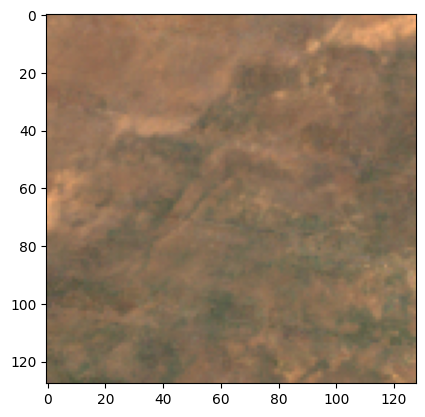

In [ ]:
import matplotlib.pyplot as plt

# Show visuals
plt.imshow(inputs_visual)
plt.show()

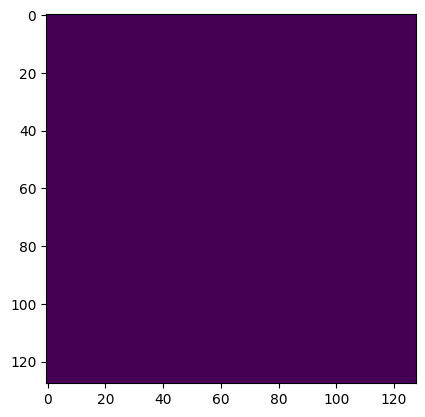

In [ ]:
# Currently 0
np.amax(labels)
plt.imshow(labels)
plt.show()

Visualizing target (again)

In [ ]:
# Showing correct(?) output
import folium

mapid = target.getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[0, 37], zoom_start = 6)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='target variable',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

Visualizing image (again...)

In [ ]:
#Showing correct output

import folium

vis_params = {
  "min": 0,
  "max": 3000,
  "bands": ["R", "G", "B"],
}
folium.Map(
    location=(0,37),
    zoom_start=6,
    tiles=image.getMapId(vis_params)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
)

## Apache-beam

Serialize to TFRecords

In [ ]:
import tensorflow as tf

def serialize(inputs: np.ndarray, labels: np.ndarray) -> bytes:
    features = {
        name: tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(data).numpy()])
        )
        for name, data in {"inputs": inputs, "labels": labels}.items()
    }
    example = tf.train.Example(features=tf.train.Features(feature=features))
    return example.SerializeToString()

serialized = serialize(inputs, labels)
print(f"serialized: {len(serialized)} bytes")

serialized: 589920 bytes


### Creating Dataset


In [ ]:
# Now let's get the code from GitHub and navigate to the sample.
!git clone https://github.com/GoogleCloudPlatform/python-docs-samples.git
%cd python-docs-samples/people-and-planet-ai/land-cover-classification

Cloning into 'python-docs-samples'...
remote: Enumerating objects: 92767, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 92767 (delta 117), reused 154 (delta 37), pack-reused 92491
Receiving objects: 100% (92767/92767), 198.05 MiB | 23.08 MiB/s, done.
Resolving deltas: 100% (55003/55003), done.
Updating files: 100% (4323/4323), done.
/content/python-docs-samples/people-and-planet-ai/land-cover-classification


In [ ]:
from create_dataset import serialize_tensorflow
inputs = inputs_visual
serialized = serialize_tensorflow(inputs, labels)
print(f"serialized: {len(serialized)} bytes")

serialized: 458848 bytes


In [ ]:
# Globals
PATCH_SIZE = 128
MAX_REQUESTS = 20
data_path=f"gs://{bucket}/land-cover/data"

In [ ]:
def run_tensorflow(
    data_path: str,
    points_per_class: int = points_per_class,
    patch_size: int = PATCH_SIZE,
    max_requests: int = MAX_REQUESTS,
    beam_args: Optional[List[str]] = None,
) -> None:
    """Runs an Apache Beam pipeline to create a dataset.
    This fetches data from Earth Engine and creates a TFRecords dataset.
    We use `max_requests` to limit the number of concurrent requests to Earth Engine
    to avoid quota issues. You can request for an increas of quota if you need it.
    Args:
        data_path: Directory path to save the TFRecord files.
        points_per_class: Number of points to get for each classification.
        patch_size: Size in pixels of the surrounding square patch.
        max_requests: Limit the number of concurrent requests to Earth Engine.
        polygons: List of polygons to pick points from.
        beam_args: Apache Beam command line arguments to parse as pipeline options.
    """
    # Equally divide the number of points by the number of concurrent requests.
    num_points = max(int(points_per_class / max_requests), 1)

    beam_options = PipelineOptions(
        beam_args,
        save_main_session=True,
        setup_file="./setup.py",
        max_num_workers=max_requests,  # distributed runners
        direct_num_workers=max(max_requests, 20),  # direct runner
        disk_size_gb=50,
    )
    with beam.Pipeline() as pipeline:
        (
            pipeline
            | "🌱 Make seeds" >> beam.Create([0])
            | "🛰 Sample points" >> beam.FlatMap(sample_points, region=region, image=labels_image, num_points=NUM_POINTS, scale=1000)
            | "📖 Get examples" >> beam.Map(get_training_example, image=image, labels=target, patch_size=PATCH_SIZE)
            | "✍🏽 Serialize" >> beam.MapTuple(serialize_tensorflow)
            | "📚 Write TFRecords" >> beam.io.WriteToTFRecord(
                f"{data_path}/part", file_name_suffix=".tfrecord.gz"
            )
        )

In [ ]:
DATA_PATH = f"gs://{bucket}/land-cover/data"

Run the adapted Apache pipeline: 

In [ ]:
run_tensorflow(data_path=DATA_PATH)

In [ ]:
# Let's take a look at the dataset files.
!ls -lh data

total 356K
-rw-r--r-- 1 root root 356K Apr 13 23:57 part-00000-of-00001.tfrecord.gz


Check wd, attach dataset, check dataset

In [ ]:
import os 
current_dir = os.getcwd()

# Print current working directory
print("Current working directory:", current_dir)

Current working directory: /content/python-docs-samples/people-and-planet-ai/land-cover-classification


In [ ]:
FILE_PATH = 'data/part-00000-of-00001.tfrecord.gz'
dataset = tf.data.TFRecordDataset(FILE_PATH, compression_type='GZIP')

print(dataset)

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [ ]:
for y  in dataset.take(2):
  #print("inputs:", x.dtype.name, x.shape)
  print("labels: {} {}".format(y.dtype.name, y.shape))

labels: string ()
labels: string ()


Next use a distributed runner to run on a larger dataset (~20 min)

In [ ]:
points_per_class = 100

!python create_dataset.py "tensorflow" \
  --data-path="gs://{bucket}/land-cover/data" \
  --points-per-class="{points_per_class}" \
  --runner="DataflowRunner" \
  --project="{project}" \
  --region="{location}" \
  --temp_location="gs://{bucket}/land-cover/temp"

INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "list[list[tuple[float, float]]]"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "Iterable[tuple[float, float]]"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "list[list[tuple[float, float]]]"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to Any: "int"
INFO:apache_beam.typehints.native_type_compatibility:Converting string literal type hint to An

In [ ]:
print(target.getInfo())

{'type': 'Image', 'bands': [{'id': 'target', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [29676, 37426], 'crs': 'EPSG:32737', 'crs_transform': [30, 0, -67088.3816999998, 0, -30, 10605534.1865]}], 'version': 1667329384912485, 'id': 'projects/sanford-project-04a9/assets/Kenya/kenya_census_2009_rast', 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[33.899676480467825, -3.712381049241454], [33.89351506051154, -4.661100260662413], [37.900507946594495, -4.678851591182628], [41.91295489440698, -4.673655155923738], [41.90670508116313, -2.7713382186237463], [41.90334965079649, -0.23517632895609153], [41.90379440308304, 1.032915523138402], [41.90893442251192, 3.5690508582490628], [41.916536101341734, 5.471324856577909], [37.899154212658445, 5.477412980838261], [33.88725958188004, 5.456615444350572], [33.902203461985884, 3.2433133930818694], [33.90731169057764, 1.978657066626101], [33.910330837555634, 0.08162750001535511], [33.9092551841757, 

In [ ]:
target.bandNames().getInfo()

['target']

In [ ]:
target = get_label_image(image)
#Visualize imagery
map_target = folium.Map(location=[0, 37], zoom_start = 6)
map_target.add_ee_layer(target, None, 'target')

display(map_target)

# Train Model

In [ ]:
# Specify names locations for outputs in Cloud Storage. 
FOLDER = 'unet_11-17_128_tiles_kenya_r_g_b_ndvi_treatment'
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

In [ ]:
!pwd

!cd ~
!cd data
!ls

/content/python-docs-samples/people-and-planet-ai/land-cover-classification
cloud-tensorflow.ipynb			pretrained-model
create_dataset.py			__pycache__
data					README.ipynb
e2e_test.py				README.md
images					requirements-test.txt
land-cover-change.ipynb			requirements.txt
MANIFEST.in				serving
noxfile_config.py			setup.py
ppai_landcover_classification.egg-info	trainer
predict_batch.py			visualize.py
predict-locations.csv


inputs: float32 (128, 128, 13)
labels: float32 (128, 128, 9)


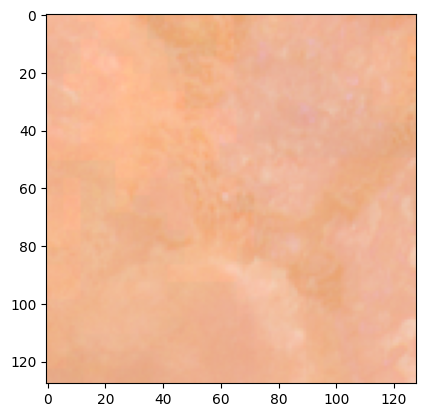

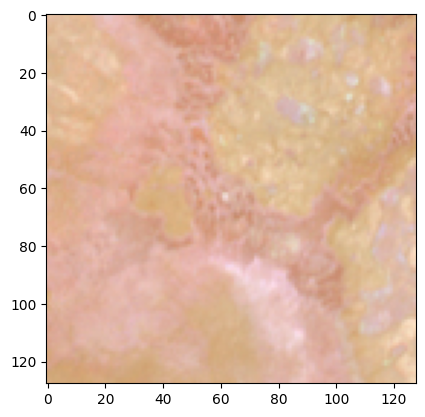

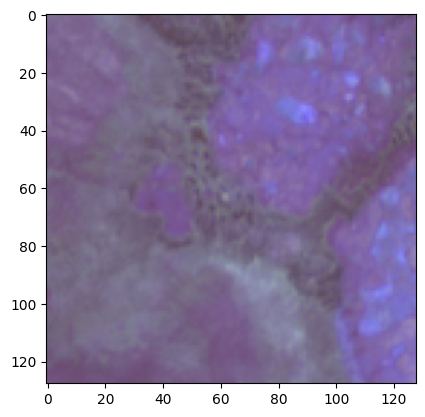

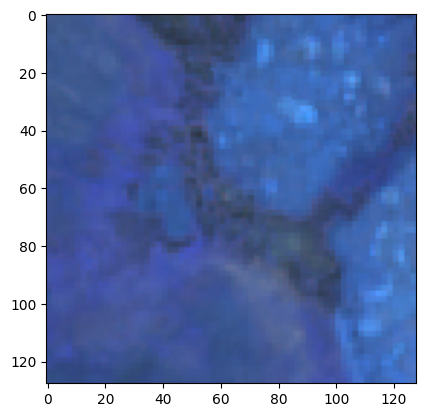

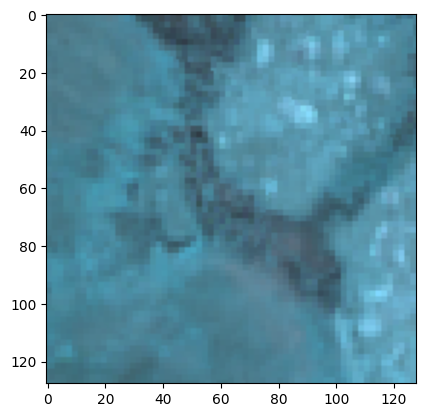

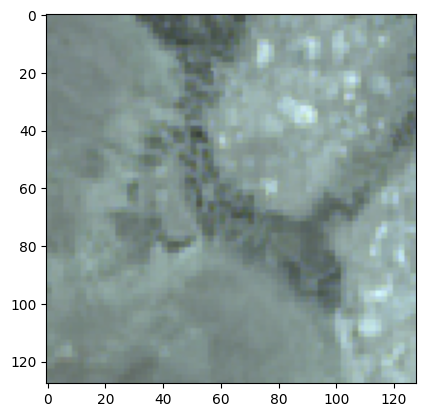

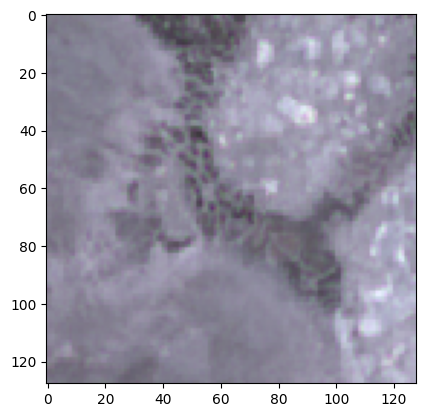

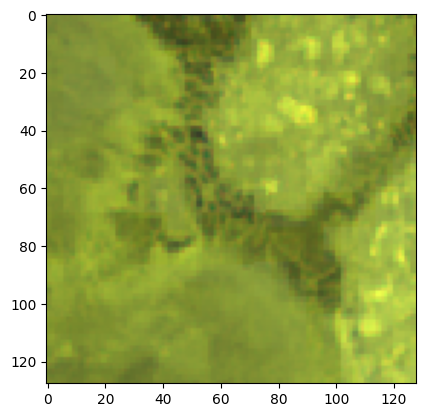

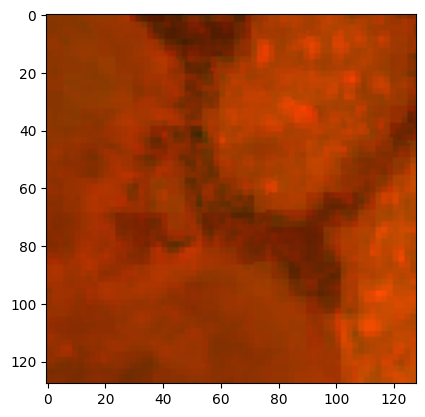

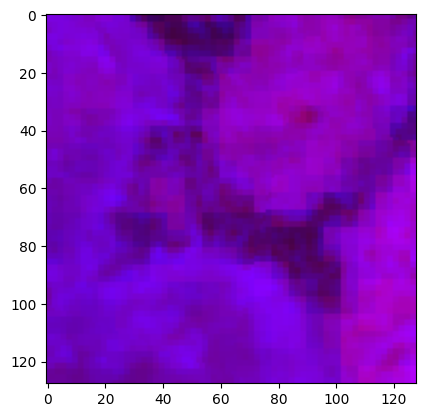

In [ ]:
from trainer.tf_model import read_dataset
import numpy as np
import matplotlib.pyplot as plt
data_path = f"gs://{bucket}/land-cover/data"
dataset = read_dataset(data_path)

for x, y in dataset.take(1):
  print("inputs:", x.dtype.name, x.shape)
  print("labels:", y.dtype.name, y.shape)
  for start_ind in range(13-3):
    inputs_visual = x[:,:, start_ind:start_ind+3]
    inputs_visual = inputs_visual/np.amax(inputs_visual)
    plt.imshow(inputs_visual)
    plt.show()

In [ ]:
print(dataset.range(8))

<RangeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [ ]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
print(len(tf.config.list_physical_devices('GPU')))


0


In [ ]:
from trainer.tf_model import create_model, split_dataset

(train_dataset, test_dataset) = split_dataset(dataset)
model = create_model(dataset)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


InvalidArgumentError: ignored